In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def mapping(x_n, r):
    x_n_plus_1 = r * x_n * (1 - x_n)

    return x_n_plus_1

In [3]:
def plot_bifurcation_map(n: int, m: int, r: np.array) -> None:
    last_m_values_for_each_r = []
    for r_k in r:
        x_i = np.random.uniform() 
        x = []
        for i in range(1, n + m):
            x_i = mapping(x_i, r_k)
            if (i >= n):
                x.append(x_i) 

        last_m_values_for_each_r.append(x)

    plt.figure(figsize=(15, 5))
    plt.plot(r, last_m_values_for_each_r, 'k.', markersize=0.15)
    
    plt.title('Bifurcation map, n={}, m={}'.format(n, m))
    plt.xlabel('r')
    plt.ylabel('x')
    plt.show()

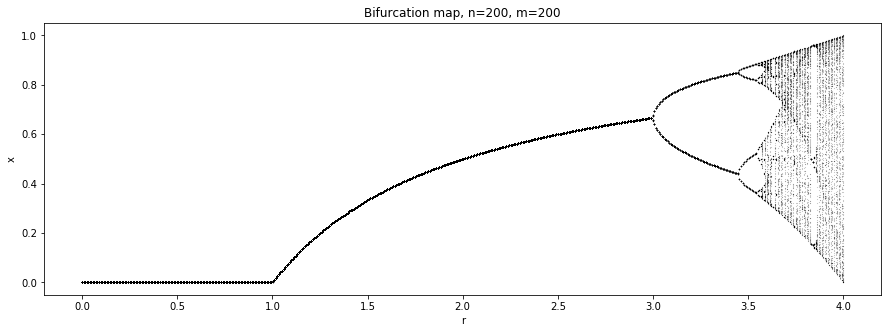

In [4]:
r_linspace = np.linspace(0, 4, num=500)
plot_bifurcation_map(200, 200, r_linspace)

In [5]:
%%writefile task_05_mpi.py

import numpy as np

from mpi4py import MPI


def mapping(x_n, r):
    return r * x_n * (1 - x_n)


comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

linspace_num = 8500000
n = 200
m = 200

r = np.linspace(0, 4, num=linspace_num)
process_size = linspace_num // size

rank_r = r[process_size * rank:process_size * rank + process_size]
if rank == (size - 1):
    rank_r = r[process_size * rank:]
    
history = np.zeros((linspace_num, m)) if rank == 0 else None

x = np.random.uniform(size=len(rank_r))
result = np.zeros((m , len(rank_r)))
for _ in range(n):
    x = mapping(x, rank_r)
for i in range(m):
    x = mapping(x, rank_r)
    result[i] = x
result = result.T

sendcounts = np.array(comm.gather(result.size, 0))

comm.Gatherv(sendbuf=result, recvbuf=(history, sendcounts), root=0)

Overwriting task_05_mpi.py


In [6]:
%%timeit -r 1
!mpirun -n 2 --allow-run-as-root --mca btl ^vader python3 task_05_mpi.py

24.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
times = []
for i in range(1, 11):
    print(f'Num of processes: {i},\t', end='')
    t = %timeit -o -r 3 !mpirun -n {i} --allow-run-as-root --mca btl ^vader python3 task_05_mpi.py
    times.append(t.best)

Num of processes: 1,	42.9 s ± 2.46 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 2,	25.1 s ± 1.16 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 3,	17.6 s ± 32.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 4,	15.1 s ± 58.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 5,	16.7 s ± 4.26 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 6,	14.8 s ± 2.94 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 7,	12 s ± 22.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 8,	11.7 s ± 27.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 9,	11.6 s ± 34.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 10,	11.4 s ± 52.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Text(0.5, 1.0, 'SpeedUp vs number of processes')

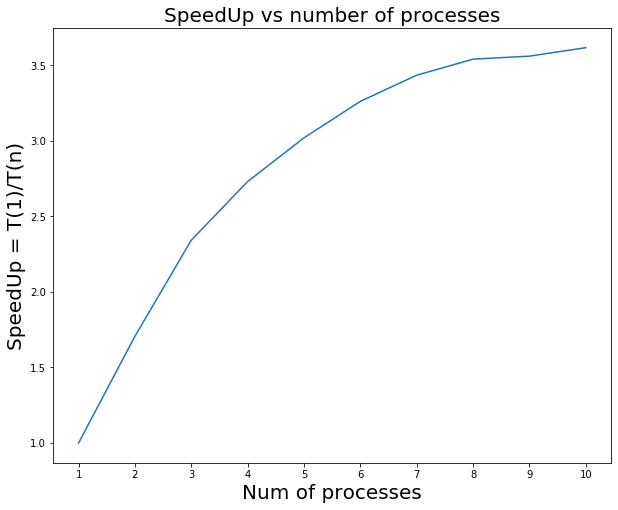

In [8]:
speedup = times[0] / np.array(times)
num_of_processes = range(1, 11)

plt.figure(figsize=(10, 8))
plt.plot(num_of_processes, speedup)
plt.xticks(num_of_processes)
plt.xlabel('Num of processes', fontsize=20)
plt.ylabel('SpeedUp = T(1)/T(n)', fontsize=20)
plt.title('SpeedUp vs number of processes', fontsize=20)